In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## define a fixed samplerate

In [2]:
samplerate=200

## load mass

In [3]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
annotations.head()

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,889.210080,177714,177842
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,906.577851,181200,181316
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,918.820873,183595,183764
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,923.198730,184464,184640
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,940.054908,187859,188011


In [5]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## define a fixed feature selection to use

In [6]:
featureSelection=loadPickle("EXT_F1_iteration_7.pkl")
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## data splits definition
leave-one-subject-out CROSS VALIDATION

In [7]:
#define subjects used in the experiment
usedSubjects=np.array(signalsMetadata['subjectId'])
usedSubjects

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016',
       '0017', '0018', '0019'], dtype=object)

In [8]:
valCount=2  #number of signals for validation (selected randomly)

trainSplits=[]
valSplits=[]
testSplits=[]
for i in range(len(usedSubjects)):
    thisTest=usedSubjects[i]
    thisNoTest=np.setdiff1d(usedSubjects,thisTest)
    thisVal=np.random.choice(thisNoTest,size=valCount,replace=False)
    thisTrain=np.setdiff1d(thisNoTest,thisVal)
    trainSplits.append(thisTrain)
    valSplits.append(thisVal)
    testSplits.append(thisTest)

dataSplits=pd.DataFrame({
    'train':trainSplits,
    'val':valSplits,
    'test':testSplits
})

dataSplits

,train,val,test
0,"[0002, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0011, 0015]",0001
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0009, 001...","[0017, 0008]",0002
2,"[0001, 0002, 0004, 0005, 0006, 0007, 0008, 000...","[0019, 0013]",0003
3,"[0001, 0002, 0003, 0006, 0007, 0008, 0009, 001...","[0005, 0015]",0004
4,"[0001, 0002, 0003, 0004, 0007, 0008, 0009, 001...","[0011, 0006]",0005
5,"[0001, 0002, 0003, 0004, 0005, 0008, 0010, 001...","[0007, 0009]",0006
6,"[0001, 0003, 0004, 0005, 0006, 0008, 0009, 001...","[0002, 0017]",0007
7,"[0002, 0003, 0004, 0005, 0007, 0009, 0010, 001...","[0001, 0006]",0008
8,"[0001, 0002, 0004, 0005, 0006, 0007, 0008, 001...","[0010, 0003]",0009
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0009, 0016]",0010


## define annotation criterium
by now we keep the labeler that went trough all the signals

In [9]:
usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]

In [10]:
usedAnnotations[['subjectId','labelerId','duration']].groupby(['subjectId','labelerId']).describe()

duration                                          \
                       count      mean       std       min       25%   
subjectId labelerId                                                    
0001      0001        1044.0  0.822037  0.202792  0.390602  0.675735   
0002      0001        1143.0  0.834582  0.195713  0.414040  0.699173   
0003      0001         143.0  0.690269  0.149652  0.460907  0.585900   
0004      0001         253.0  0.829708  0.224842  0.492157  0.667923   
0005      0001         341.0  0.706104  0.131805  0.425751  0.613243   
0006      0001         150.0  0.761306  0.143614  0.492157  0.679642   
0007      0001         912.0  0.892692  0.226504  0.425751  0.730423   
0008      0001         385.0  0.846882  0.227884  0.441376  0.695267   
0009      0001         814.0  0.923970  0.216783  0.468719  0.773392   
0010      0001         795.0  0.815081  0.190663  0.402321  0.687454   
0011      0001         606.0  0.923982  0.222469  0.503876  0.773384   
0012      0001         709.0  0.836528  0.180787  0.437469  0.706985   
0013      0001         698.0  0.910960  0.245084  0.437477  0.742142   
0014      0001         713.0  0.805534  0.205166  0.406227  0.671829   
0015      0001          97.0  0.739281  0.106173  0.519501  0.671829   
0016      0001         452.0  0.806943  0.210937  0.335915  0.640587   
0017      0001         470.0  0.802766  0.155081  0.437469  0.694296   
0018      0001        1164.0  0.844465  0.185415  0.421852  0.722610   
0019      0001         315.0  0.770511  0.129903  0.453094  0.687454   

                                                   
                          50%       75%       max  
subjectId labelerId                                
0001      0001       0.796822  0.945251  1.839722  
0002      0001       0.816353  0.937439  1.820198  
0003      0001       0.648399  0.775341  1.160080  
0004      0001       0.785103  0.945251  1.675674  
0005      0001       0.699173  0.781197  1.195236  
0006      0001       0.749954  0.847603  1.480377  
0007      0001       0.867134  1.003845  2.042839  
0008      0001       0.800728  0.937439  1.925659  
0009      0001       0.890568  1.027275  1.882690  
0010      0001       0.773392  0.921814  1.847542  
0011      0001       0.890564  1.042900  2.015495  
0012      0001       0.808548  0.956970  1.495995  
0013      0001       0.871036  1.026300  2.117058  
0014      0001       0.773392  0.906197  2.218605  
0015      0001       0.722610  0.808540  1.011650  
0016      0001       0.773384  0.925720  1.679581  
0017      0001       0.781200  0.890570  1.644424  
0018      0001       0.824165  0.941345  1.882690  
0019      0001       0.757767  0.839790  1.359291

## model fitting

In [11]:
n_jobs=6 # paralelization parameter for xgboost (keep it 8 as maximum)

models=[]
treeLimits=[]
valF1s=[]
for index, row in dataSplits.iterrows():
    #Features
    trainFeatures=loadFeatureMatrix(row.train,featureSelection,signalsMetadata,samplerate,datapath)
    valFeatures=loadFeatureMatrix(row.val,featureSelection,signalsMetadata,samplerate,datapath)
    #Labels
    trainLabels=loadLabelsVector(row.train,usedAnnotations,signalsMetadata,samplerate)
    valLabels=loadLabelsVector(row.val,usedAnnotations,signalsMetadata,samplerate)
    #Train the models
    xgb_model = xgb.XGBClassifier(n_jobs=n_jobs).fit(trainFeatures, trainLabels, early_stopping_rounds=3, eval_metric="logloss",eval_set=[(valFeatures,valLabels)])
    models.append(xgb_model)
    treeLimits.append(xgb_model.best_ntree_limit)
    #val predictions and objective function definition
    valPredictions=xgb_model.predict(valFeatures, ntree_limit=xgb_model.best_ntree_limit)
    valF1s.append(F1(valLabels,valPredictions))

dataSplits["model"]=models
dataSplits["treeLimit"]=treeLimits
dataSplits["valF1"]=valF1s


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44833
[1]	validation_0-logloss:0.31320
[2]	validation_0-logloss:0.22841
[3]	validation_0-logloss:0.17201
[4]	validation_0-logloss:0.13325
[5]	validation_0-logloss:0.10604
[6]	validation_0-logloss:0.08674
[7]	validation_0-logloss:0.07288
[8]	validation_0-logloss:0.06288
[9]	validation_0-logloss:0.05566
[10]	validation_0-logloss:0.05041
[11]	validation_0-logloss:0.04662
[12]	validation_0-logloss:0.04391
[13]	validation_0-logloss:0.04197
[14]	validation_0-logloss:0.04059
[15]	validation_0-logloss:0.03951
[16]	validation_0-logloss:0.03877
[17]	validation_0-logloss:0.03825
[18]	validation_0-logloss:0.03784
[19]	validation_0-logloss:0.03756
[20]	validation_0-logloss:0.03731
[21]	validation_0-logloss:0.03721
[22]	validation_0-logloss:0.03706
[23]	validation_0-logloss:0.03699
[24]	validation_0-logloss:0.03691
[25]	validation_0-logloss:0.03683
[26]	validation_0-logloss:0.03681
[27]	validation_0-logloss:0.03676
[28]	validation_0-logloss:0.03676
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45109
[1]	validation_0-logloss:0.31801
[2]	validation_0-logloss:0.23515
[3]	validation_0-logloss:0.18065
[4]	validation_0-logloss:0.14382
[5]	validation_0-logloss:0.11859
[6]	validation_0-logloss:0.10121
[7]	validation_0-logloss:0.08927
[8]	validation_0-logloss:0.08114
[9]	validation_0-logloss:0.07566
[10]	validation_0-logloss:0.07207
[11]	validation_0-logloss:0.06976
[12]	validation_0-logloss:0.06833
[13]	validation_0-logloss:0.06748
[14]	validation_0-logloss:0.06703
[15]	validation_0-logloss:0.06682
[16]	validation_0-logloss:0.06675
[17]	validation_0-logloss:0.06674
[18]	validation_0-logloss:0.06678
[19]	validation_0-logloss:0.06683
[20]	validation_0-logloss:0.06687


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45395
[1]	validation_0-logloss:0.32230
[2]	validation_0-logloss:0.24023
[3]	validation_0-logloss:0.18621
[4]	validation_0-logloss:0.14959
[5]	validation_0-logloss:0.12444
[6]	validation_0-logloss:0.10705
[7]	validation_0-logloss:0.09503
[8]	validation_0-logloss:0.08669
[9]	validation_0-logloss:0.08098
[10]	validation_0-logloss:0.07712
[11]	validation_0-logloss:0.07452
[12]	validation_0-logloss:0.07280
[13]	validation_0-logloss:0.07168
[14]	validation_0-logloss:0.07096
[15]	validation_0-logloss:0.07047
[16]	validation_0-logloss:0.07017
[17]	validation_0-logloss:0.07007
[18]	validation_0-logloss:0.06994
[19]	validation_0-logloss:0.06988
[20]	validation_0-logloss:0.06991
[21]	validation_0-logloss:0.06988
[22]	validation_0-logloss:0.06990
[23]	validation_0-logloss:0.06992
[24]	validation_0-logloss:0.06995


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44565
[1]	validation_0-logloss:0.30883
[2]	validation_0-logloss:0.22292
[3]	validation_0-logloss:0.16581
[4]	validation_0-logloss:0.12665
[5]	validation_0-logloss:0.09930
[6]	validation_0-logloss:0.08000
[7]	validation_0-logloss:0.06631
[8]	validation_0-logloss:0.05657
[9]	validation_0-logloss:0.04965
[10]	validation_0-logloss:0.04476
[11]	validation_0-logloss:0.04126
[12]	validation_0-logloss:0.03882
[13]	validation_0-logloss:0.03710
[14]	validation_0-logloss:0.03588
[15]	validation_0-logloss:0.03506
[16]	validation_0-logloss:0.03446
[17]	validation_0-logloss:0.03405
[18]	validation_0-logloss:0.03377
[19]	validation_0-logloss:0.03357
[20]	validation_0-logloss:0.03342
[21]	validation_0-logloss:0.03331
[22]	validation_0-logloss:0.03324
[23]	validation_0-logloss:0.03319
[24]	validation_0-logloss:0.03316
[25]	validation_0-logloss:0.03313
[26]	validation_0-logloss:0.03311
[27]	validation_0-logloss:0.03309
[28]	validation_0-logloss:0.03308
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44937
[1]	validation_0-logloss:0.31466
[2]	validation_0-logloss:0.23007
[3]	validation_0-logloss:0.17371
[4]	validation_0-logloss:0.13490
[5]	validation_0-logloss:0.10760
[6]	validation_0-logloss:0.08817
[7]	validation_0-logloss:0.07413
[8]	validation_0-logloss:0.06396
[9]	validation_0-logloss:0.05656
[10]	validation_0-logloss:0.05124
[11]	validation_0-logloss:0.04731
[12]	validation_0-logloss:0.04449
[13]	validation_0-logloss:0.04234
[14]	validation_0-logloss:0.04088
[15]	validation_0-logloss:0.03972
[16]	validation_0-logloss:0.03895
[17]	validation_0-logloss:0.03830
[18]	validation_0-logloss:0.03792
[19]	validation_0-logloss:0.03752
[20]	validation_0-logloss:0.03728
[21]	validation_0-logloss:0.03717
[22]	validation_0-logloss:0.03703
[23]	validation_0-logloss:0.03692
[24]	validation_0-logloss:0.03682
[25]	validation_0-logloss:0.03676
[26]	validation_0-logloss:0.03673
[27]	validation_0-logloss:0.03670
[28]	validation_0-logloss:0.03670
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.46049
[1]	validation_0-logloss:0.33403
[2]	validation_0-logloss:0.25648
[3]	validation_0-logloss:0.20648
[4]	validation_0-logloss:0.17354
[5]	validation_0-logloss:0.15174
[6]	validation_0-logloss:0.13742
[7]	validation_0-logloss:0.12815
[8]	validation_0-logloss:0.12235
[9]	validation_0-logloss:0.11898
[10]	validation_0-logloss:0.11710
[11]	validation_0-logloss:0.11637
[12]	validation_0-logloss:0.11614
[13]	validation_0-logloss:0.11627
[14]	validation_0-logloss:0.11662


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45341
[1]	validation_0-logloss:0.32200
[2]	validation_0-logloss:0.24025
[3]	validation_0-logloss:0.18642
[4]	validation_0-logloss:0.14990
[5]	validation_0-logloss:0.12469
[6]	validation_0-logloss:0.10711
[7]	validation_0-logloss:0.09484
[8]	validation_0-logloss:0.08621
[9]	validation_0-logloss:0.08023
[10]	validation_0-logloss:0.07606
[11]	validation_0-logloss:0.07328
[12]	validation_0-logloss:0.07134
[13]	validation_0-logloss:0.07007
[14]	validation_0-logloss:0.06937
[15]	validation_0-logloss:0.06882
[16]	validation_0-logloss:0.06842
[17]	validation_0-logloss:0.06818
[18]	validation_0-logloss:0.06811
[19]	validation_0-logloss:0.06801
[20]	validation_0-logloss:0.06795
[21]	validation_0-logloss:0.06797
[22]	validation_0-logloss:0.06792
[23]	validation_0-logloss:0.06790
[24]	validation_0-logloss:0.06784
[25]	validation_0-logloss:0.06787
[26]	validation_0-logloss:0.06781
[27]	validation_0-logloss:0.06780
[28]	validation_0-logloss:0.06781
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45049
[1]	validation_0-logloss:0.31734
[2]	validation_0-logloss:0.23448
[3]	validation_0-logloss:0.17981
[4]	validation_0-logloss:0.14266
[5]	validation_0-logloss:0.11693
[6]	validation_0-logloss:0.09889
[7]	validation_0-logloss:0.08614
[8]	validation_0-logloss:0.07709
[9]	validation_0-logloss:0.07058
[10]	validation_0-logloss:0.06599
[11]	validation_0-logloss:0.06271
[12]	validation_0-logloss:0.06029
[13]	validation_0-logloss:0.05858
[14]	validation_0-logloss:0.05727
[15]	validation_0-logloss:0.05637
[16]	validation_0-logloss:0.05572
[17]	validation_0-logloss:0.05525
[18]	validation_0-logloss:0.05478
[19]	validation_0-logloss:0.05451
[20]	validation_0-logloss:0.05429
[21]	validation_0-logloss:0.05411
[22]	validation_0-logloss:0.05401
[23]	validation_0-logloss:0.05394
[24]	validation_0-logloss:0.05388
[25]	validation_0-logloss:0.05377
[26]	validation_0-logloss:0.05376
[27]	validation_0-logloss:0.05373
[28]	validation_0-logloss:0.05368
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44912
[1]	validation_0-logloss:0.31501
[2]	validation_0-logloss:0.23140
[3]	validation_0-logloss:0.17631
[4]	validation_0-logloss:0.13889
[5]	validation_0-logloss:0.11312
[6]	validation_0-logloss:0.09524
[7]	validation_0-logloss:0.08282
[8]	validation_0-logloss:0.07423
[9]	validation_0-logloss:0.06831
[10]	validation_0-logloss:0.06428
[11]	validation_0-logloss:0.06157
[12]	validation_0-logloss:0.05976
[13]	validation_0-logloss:0.05856
[14]	validation_0-logloss:0.05779
[15]	validation_0-logloss:0.05729
[16]	validation_0-logloss:0.05701
[17]	validation_0-logloss:0.05682
[18]	validation_0-logloss:0.05673
[19]	validation_0-logloss:0.05667
[20]	validation_0-logloss:0.05663
[21]	validation_0-logloss:0.05663
[22]	validation_0-logloss:0.05664
[23]	validation_0-logloss:0.05663


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45376
[1]	validation_0-logloss:0.32272
[2]	validation_0-logloss:0.24147
[3]	validation_0-logloss:0.18827
[4]	validation_0-logloss:0.15247
[5]	validation_0-logloss:0.12804
[6]	validation_0-logloss:0.11129
[7]	validation_0-logloss:0.09981
[8]	validation_0-logloss:0.09200
[9]	validation_0-logloss:0.08674
[10]	validation_0-logloss:0.08326
[11]	validation_0-logloss:0.08099
[12]	validation_0-logloss:0.07957
[13]	validation_0-logloss:0.07868
[14]	validation_0-logloss:0.07819
[15]	validation_0-logloss:0.07791
[16]	validation_0-logloss:0.07777
[17]	validation_0-logloss:0.07771
[18]	validation_0-logloss:0.07769
[19]	validation_0-logloss:0.07769
[20]	validation_0-logloss:0.07769
[21]	validation_0-logloss:0.07769
[22]	validation_0-logloss:0.07769
[23]	validation_0-logloss:0.07768
[24]	validation_0-logloss:0.07766
[25]	validation_0-logloss:0.07767
[26]	validation_0-logloss:0.07765
[27]	validation_0-logloss:0.07766
[28]	validation_0-logloss:0.07767
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45305
[1]	validation_0-logloss:0.32076
[2]	validation_0-logloss:0.23816
[3]	validation_0-logloss:0.18373
[4]	validation_0-logloss:0.14677
[5]	validation_0-logloss:0.12124
[6]	validation_0-logloss:0.10351
[7]	validation_0-logloss:0.09118
[8]	validation_0-logloss:0.08256
[9]	validation_0-logloss:0.07659
[10]	validation_0-logloss:0.07246
[11]	validation_0-logloss:0.06966
[12]	validation_0-logloss:0.06773
[13]	validation_0-logloss:0.06642
[14]	validation_0-logloss:0.06557
[15]	validation_0-logloss:0.06500
[16]	validation_0-logloss:0.06464
[17]	validation_0-logloss:0.06438
[18]	validation_0-logloss:0.06423
[19]	validation_0-logloss:0.06417
[20]	validation_0-logloss:0.06413
[21]	validation_0-logloss:0.06409
[22]	validation_0-logloss:0.06409
[23]	validation_0-logloss:0.06409
[24]	validation_0-logloss:0.06409


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44511
[1]	validation_0-logloss:0.30797
[2]	validation_0-logloss:0.22177
[3]	validation_0-logloss:0.16440
[4]	validation_0-logloss:0.12496
[5]	validation_0-logloss:0.09732
[6]	validation_0-logloss:0.07774
[7]	validation_0-logloss:0.06378
[8]	validation_0-logloss:0.05380
[9]	validation_0-logloss:0.04663
[10]	validation_0-logloss:0.04148
[11]	validation_0-logloss:0.03776
[12]	validation_0-logloss:0.03512
[13]	validation_0-logloss:0.03322
[14]	validation_0-logloss:0.03187
[15]	validation_0-logloss:0.03090
[16]	validation_0-logloss:0.03020
[17]	validation_0-logloss:0.02971
[18]	validation_0-logloss:0.02937
[19]	validation_0-logloss:0.02912
[20]	validation_0-logloss:0.02895
[21]	validation_0-logloss:0.02882
[22]	validation_0-logloss:0.02872
[23]	validation_0-logloss:0.02866
[24]	validation_0-logloss:0.02860
[25]	validation_0-logloss:0.02858
[26]	validation_0-logloss:0.02856
[27]	validation_0-logloss:0.02855
[28]	validation_0-logloss:0.02853
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45824
[1]	validation_0-logloss:0.32911
[2]	validation_0-logloss:0.24870
[3]	validation_0-logloss:0.19570
[4]	validation_0-logloss:0.15962
[5]	validation_0-logloss:0.13471
[6]	validation_0-logloss:0.11707
[7]	validation_0-logloss:0.10466
[8]	validation_0-logloss:0.09572
[9]	validation_0-logloss:0.08936
[10]	validation_0-logloss:0.08472
[11]	validation_0-logloss:0.08155
[12]	validation_0-logloss:0.07915
[13]	validation_0-logloss:0.07749
[14]	validation_0-logloss:0.07619
[15]	validation_0-logloss:0.07545
[16]	validation_0-logloss:0.07485
[17]	validation_0-logloss:0.07425
[18]	validation_0-logloss:0.07397
[19]	validation_0-logloss:0.07365
[20]	validation_0-logloss:0.07356
[21]	validation_0-logloss:0.07333
[22]	validation_0-logloss:0.07318
[23]	validation_0-logloss:0.07307
[24]	validation_0-logloss:0.07299
[25]	validation_0-logloss:0.07299
[26]	validation_0-logloss:0.07292
[27]	validation_0-logloss:0.07284
[28]	validation_0-logloss:0.07285
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44628
[1]	validation_0-logloss:0.30975
[2]	validation_0-logloss:0.22397
[3]	validation_0-logloss:0.16690
[4]	validation_0-logloss:0.12770
[5]	validation_0-logloss:0.10028
[6]	validation_0-logloss:0.08087
[7]	validation_0-logloss:0.06706
[8]	validation_0-logloss:0.05721
[9]	validation_0-logloss:0.05013
[10]	validation_0-logloss:0.04508
[11]	validation_0-logloss:0.04148
[12]	validation_0-logloss:0.03893
[13]	validation_0-logloss:0.03711
[14]	validation_0-logloss:0.03582
[15]	validation_0-logloss:0.03492
[16]	validation_0-logloss:0.03426
[17]	validation_0-logloss:0.03381
[18]	validation_0-logloss:0.03348
[19]	validation_0-logloss:0.03327
[20]	validation_0-logloss:0.03310
[21]	validation_0-logloss:0.03298
[22]	validation_0-logloss:0.03290
[23]	validation_0-logloss:0.03283
[24]	validation_0-logloss:0.03280
[25]	validation_0-logloss:0.03278
[26]	validation_0-logloss:0.03275
[27]	validation_0-logloss:0.03273
[28]	validation_0-logloss:0.03272
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44980
[1]	validation_0-logloss:0.31541
[2]	validation_0-logloss:0.23124
[3]	validation_0-logloss:0.17543
[4]	validation_0-logloss:0.13729
[5]	validation_0-logloss:0.11073
[6]	validation_0-logloss:0.09202
[7]	validation_0-logloss:0.07879
[8]	validation_0-logloss:0.06940
[9]	validation_0-logloss:0.06272
[10]	validation_0-logloss:0.05799
[11]	validation_0-logloss:0.05465
[12]	validation_0-logloss:0.05232
[13]	validation_0-logloss:0.05064
[14]	validation_0-logloss:0.04944
[15]	validation_0-logloss:0.04860
[16]	validation_0-logloss:0.04803
[17]	validation_0-logloss:0.04761
[18]	validation_0-logloss:0.04732
[19]	validation_0-logloss:0.04713
[20]	validation_0-logloss:0.04697
[21]	validation_0-logloss:0.04687
[22]	validation_0-logloss:0.04677
[23]	validation_0-logloss:0.04670
[24]	validation_0-logloss:0.04666
[25]	validation_0-logloss:0.04660
[26]	validation_0-logloss:0.04657
[27]	validation_0-logloss:0.04656
[28]	validation_0-logloss:0.04654
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45273
[1]	validation_0-logloss:0.32057
[2]	validation_0-logloss:0.23810
[3]	validation_0-logloss:0.18362
[4]	validation_0-logloss:0.14650
[5]	validation_0-logloss:0.12068
[6]	validation_0-logloss:0.10250
[7]	validation_0-logloss:0.08966
[8]	validation_0-logloss:0.08047
[9]	validation_0-logloss:0.07402
[10]	validation_0-logloss:0.06935
[11]	validation_0-logloss:0.06602
[12]	validation_0-logloss:0.06371
[13]	validation_0-logloss:0.06195
[14]	validation_0-logloss:0.06077
[15]	validation_0-logloss:0.06000
[16]	validation_0-logloss:0.05946
[17]	validation_0-logloss:0.05896
[18]	validation_0-logloss:0.05856
[19]	validation_0-logloss:0.05828
[20]	validation_0-logloss:0.05816
[21]	validation_0-logloss:0.05801
[22]	validation_0-logloss:0.05799
[23]	validation_0-logloss:0.05790
[24]	validation_0-logloss:0.05780
[25]	validation_0-logloss:0.05778
[26]	validation_0-logloss:0.05771
[27]	validation_0-logloss:0.05770
[28]	validation_0-logloss:0.05766
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45600
[1]	validation_0-logloss:0.32646
[2]	validation_0-logloss:0.24610
[3]	validation_0-logloss:0.19347
[4]	validation_0-logloss:0.15785
[5]	validation_0-logloss:0.13329
[6]	validation_0-logloss:0.11618
[7]	validation_0-logloss:0.10412
[8]	validation_0-logloss:0.09562
[9]	validation_0-logloss:0.08956
[10]	validation_0-logloss:0.08529
[11]	validation_0-logloss:0.08223
[12]	validation_0-logloss:0.07998
[13]	validation_0-logloss:0.07840
[14]	validation_0-logloss:0.07716
[15]	validation_0-logloss:0.07633
[16]	validation_0-logloss:0.07568
[17]	validation_0-logloss:0.07520
[18]	validation_0-logloss:0.07491
[19]	validation_0-logloss:0.07456
[20]	validation_0-logloss:0.07431
[21]	validation_0-logloss:0.07416
[22]	validation_0-logloss:0.07399
[23]	validation_0-logloss:0.07385
[24]	validation_0-logloss:0.07377
[25]	validation_0-logloss:0.07370
[26]	validation_0-logloss:0.07363
[27]	validation_0-logloss:0.07356
[28]	validation_0-logloss:0.07350
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45758
[1]	validation_0-logloss:0.32955
[2]	validation_0-logloss:0.25091
[3]	validation_0-logloss:0.19995
[4]	validation_0-logloss:0.16615
[5]	validation_0-logloss:0.14350
[6]	validation_0-logloss:0.12826
[7]	validation_0-logloss:0.11808
[8]	validation_0-logloss:0.11136
[9]	validation_0-logloss:0.10700
[10]	validation_0-logloss:0.10419
[11]	validation_0-logloss:0.10255
[12]	validation_0-logloss:0.10165
[13]	validation_0-logloss:0.10103
[14]	validation_0-logloss:0.10079
[15]	validation_0-logloss:0.10059
[16]	validation_0-logloss:0.10061
[17]	validation_0-logloss:0.10062
[18]	validation_0-logloss:0.10066


\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45056
[1]	validation_0-logloss:0.31646
[2]	validation_0-logloss:0.23234
[3]	validation_0-logloss:0.17648
[4]	validation_0-logloss:0.13821
[5]	validation_0-logloss:0.11148
[6]	validation_0-logloss:0.09259
[7]	validation_0-logloss:0.07916
[8]	validation_0-logloss:0.06959
[9]	validation_0-logloss:0.06271
[10]	validation_0-logloss:0.05778
[11]	validation_0-logloss:0.05425
[12]	validation_0-logloss:0.05171
[13]	validation_0-logloss:0.04990
[14]	validation_0-logloss:0.04861
[15]	validation_0-logloss:0.04768
[16]	validation_0-logloss:0.04702
[17]	validation_0-logloss:0.04655
[18]	validation_0-logloss:0.04621
[19]	validation_0-logloss:0.04598
[20]	validation_0-logloss:0.04580
[21]	validation_0-logloss:0.04568
[22]	validation_0-logloss:0.04559
[23]	validation_0-logloss:0.04553
[24]	validation_0-logloss:0.04550
[25]	validation_0-logloss:0.04547
[26]	validation_0-logloss:0.04544
[27]	validation_0-logloss:0.04542
[28]	validation_0-logloss:0.04541
[29]	validation_0-loglos

\\desktop-447dqph\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [12]:
dataSplits

,train,val,test,model,treeLimit,valF1
0,"[0002, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0011, 0015]",0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",51,0.000000
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0009, 001...","[0017, 0008]",0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",18,0.000000
2,"[0001, 0002, 0004, 0005, 0006, 0007, 0008, 000...","[0019, 0013]",0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",22,0.000023
3,"[0001, 0002, 0003, 0006, 0007, 0008, 0009, 001...","[0005, 0015]",0004,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.000000
4,"[0001, 0002, 0003, 0004, 0007, 0008, 0009, 001...","[0011, 0006]",0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",48,0.000000
5,"[0001, 0002, 0003, 0004, 0005, 0008, 0010, 001...","[0007, 0009]",0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",13,0.000000
6,"[0001, 0003, 0004, 0005, 0006, 0008, 0009, 001...","[0002, 0017]",0007,"XGBClassifier(base_score=0.5, booster='gbtree'...",41,0.000053
7,"[0002, 0003, 0004, 0005, 0007, 0009, 0010, 001...","[0001, 0006]",0008,"XGBClassifier(base_score=0.5, booster='gbtree'...",41,0.000000
8,"[0001, 0002, 0004, 0005, 0006, 0007, 0008, 001...","[0010, 0003]",0009,"XGBClassifier(base_score=0.5, booster='gbtree'...",21,0.000000
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0009, 0016]",0010,"XGBClassifier(base_score=0.5, booster='gbtree'...",27,0.000000


In [13]:
dumpPickle(".CV_temporal.pkl",dataSplits)

In [14]:
trainLabels.shape

(94361600,)

In [15]:
valLabels.shape

(12987200,)

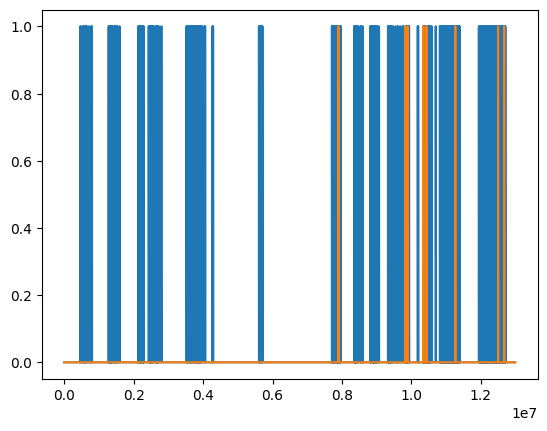

In [18]:
plt.plot(valLabels)
plt.plot(valPredictions)

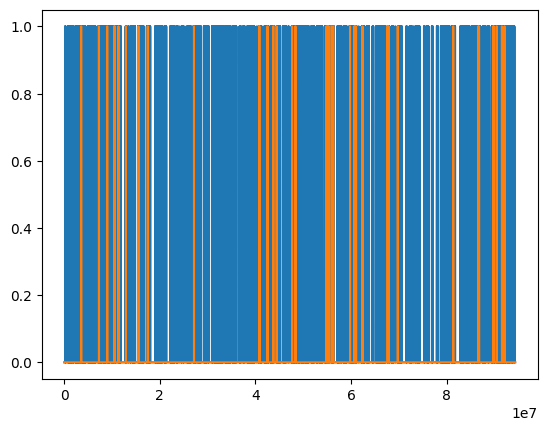

In [20]:
plt.plot(trainLabels)
plt.plot(xgb_model.predict(trainFeatures))


In [24]:
valFeatures.shape

(12987200, 5)

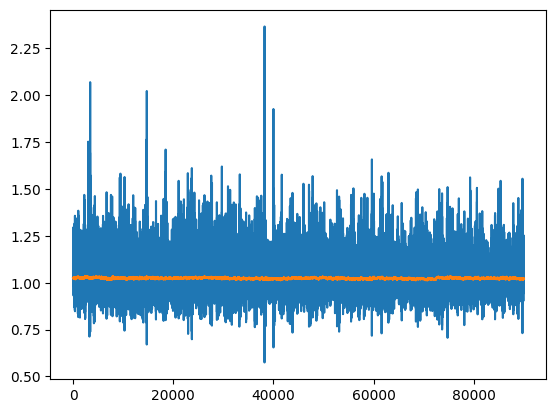

In [44]:

plt.plot(valFeatures[10000:100000,4])
plt.plot(valFeatures[10000:100000,1])
